<a href="https://colab.research.google.com/github/HAITAME/DL_Lab4/blob/main/Part_2_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'abstract-art-gallery:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F742030%2F3108204%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240415%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240415T200023Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D68b750e2535f04d16dfb6a111e54ebeedc167627fe59c2b731cd394325866b541416463c88c1dfc0bb77d9a436a154a16e4d3be611b7b4491fbd53e913cfee565b7531053d563663e27b732222d4e04cc70ec914d059a9f1b24f8f279af5dfe85c063ab8f0160f9aa9a9d820fe0a2cc39d22b9fc519388d2ceffbe9cb12e43925f5fafaa3e762d16a1d128386efd8d84c4b6198f1aa401b5893d54f8232e078b4b679d4348bfbf5510d459015f0fd1ae6fdebd16e0a84364c6f462bb999f9d8cd7eb02b29dd940d085ae87e2afc1ddebef525ff618ef6ef984c6d3a9c150e8e92449ccaf9fee941193840ad8d09b1dfd7c8994a9e3668636c589ee33600ba9b0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms , datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [ ]:
data_path = "/kaggle/input/abstract-art-gallery"
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_shape[0] * img_shape[1] * img_shape[2]),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_shape[0] * img_shape[1] * img_shape[2], 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Define Loss Function
adversarial_loss = nn.BCELoss()

latent_dim = 100
img_shape = (3, 64, 64)
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)


In [ ]:
# GPU Setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageFolder(root='/kaggle/input/abstract-art-gallery', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 50
g_losses = []
d_losses = []
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        real_imgs = imgs.to(device)

        optimizer_G.zero_grad()

        z = torch.randn(imgs.size(0), latent_dim, device=device)

        gen_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        print(
            f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
        )


[Epoch 0/50] [Batch 0/45] [D loss: 0.6920589208602905] [G loss: 0.7038884162902832]
[Epoch 0/50] [Batch 1/45] [D loss: 0.5785114765167236] [G loss: 0.8416694402694702]
[Epoch 0/50] [Batch 2/45] [D loss: 0.4143424928188324] [G loss: 0.9872580766677856]
[Epoch 0/50] [Batch 3/45] [D loss: 0.3152399957180023] [G loss: 1.1805002689361572]
[Epoch 0/50] [Batch 4/45] [D loss: 0.2536158561706543] [G loss: 1.3683769702911377]
[Epoch 0/50] [Batch 5/45] [D loss: 0.19318512082099915] [G loss: 1.4986921548843384]
[Epoch 0/50] [Batch 6/45] [D loss: 0.19366300106048584] [G loss: 1.5055792331695557]
[Epoch 0/50] [Batch 7/45] [D loss: 0.1871953308582306] [G loss: 1.398484706878662]
[Epoch 0/50] [Batch 8/45] [D loss: 0.20983603596687317] [G loss: 1.259535551071167]
[Epoch 0/50] [Batch 9/45] [D loss: 0.23650936782360077] [G loss: 1.1697754859924316]
[Epoch 0/50] [Batch 10/45] [D loss: 0.2203805148601532] [G loss: 1.1302490234375]
[Epoch 0/50] [Batch 11/45] [D loss: 0.2665519118309021] [G loss: 1.124093413

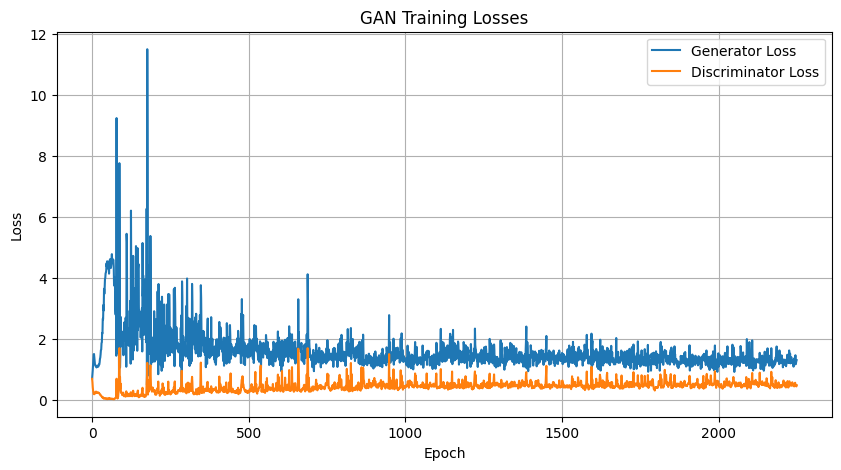

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torchvision.utils as vutils
import numpy as np

num_samples = 16
z = torch.randn(num_samples, latent_dim, device=device)
with torch.no_grad():
    fake_images = generator(z).detach().cpu()

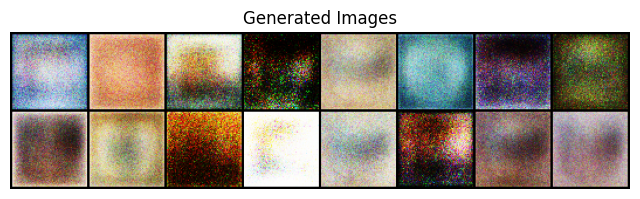

In [ ]:
# Plot the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()